# Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import copy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')

# Data and constants

In [2]:
lts_list = ['0-7', '2-22', '3-22', '6-35', '7-24', '9-21', '11-22', '12-14', '12-26', '13-11', '13-19', '14-27', '15-3', '16-11']
df_list = []
df_by_category_list = []

path = '/Users/feliperuiz/Desktop/github/stackage-evolution/notebooks'

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'{path}/lts-{lts}/lts-{lts}.df')
    df_list.append(df)
    
for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'{path}/lts-{lts}/lts-{lts}-by-category.df')
    df_by_category_list.append(df)

# top categories



In [17]:
categories = ['data', 'web', 'control', 'text', 'network']

df_by_cat = []
for idx, df in enumerate(df_by_category_list):
    aux_df = df[['package', 'category']]
    aux_df = aux_df.groupby(['category']).count().reset_index().rename(columns={"package": "count"})
    aux_df.loc[:, 'version'] = lts_list[idx]
    df_by_cat.append(aux_df.sort_values(by=['count'], ascending=False))

data = {}
for idx, df in enumerate(df_by_cat):
    categories = list(df.head(10)['category'])
    data[lts_list[idx]] = categories

df = pd.DataFrame(data)
df

,0-7,2-22,3-22,6-35,7-24,9-21,11-22,12-14,12-26,13-11,13-19,14-27,15-3,16-11
0,data,data,data,data,data,data,data,data,data,data,data,data,data,data
1,web,web,web,web,network,network,web,web,web,web,web,web,web,web
2,control,control,network,network,web,web,network,network,network,text,text,text,text,text
3,text,network,text,text,text,text,text,text,text,network,network,control,network,network
4,system,text,control,control,cloud,cloud,control,control,control,control,control,system,control,control
5,testing,system,system,system,control,control,system,system,system,system,system,testing,system,system
6,network,development,development,development,system,system,testing,testing,testing,testing,testing,network,testing,testing
7,development,graphics,testing,aws,google,google,aws,math,math,aws,aws,math,math,math
8,yesod,testing,distributed computing,graphics,development,aws,math,aws,aws,cloud,cloud,database,aws,aws
9,graphics,distributed computing,cloud,cloud,math,distributed computing,database,distributed computing,distributed computing,distributed computing,distributed computing,development,cloud,distributed computing


# RQ0. Distribution

In this section, we respond the following two questions:

- How are packages distributed in stackage?
- How are packages using mtl distributed in Stackage?

For this, we make the following graphs

1. Line graph that shows the number of packets for each published snapshot over time
2. Bar graph that shows the evolution of the main categories of the packages
3. Bar graph that shows the evolution of the stabilities of the packages
4. Bar graph that shows the evolution of the main categories of the packages that depend of `mtl`
5. Bar graph that shows the evolution of the stabilities of the packages that depend of `mtl`

## RQ0. 1 - Line graph that shows the number of packets for each published snapshot over time

In [109]:
from datetime import datetime,timedelta

total_pkgs = []
lts_datetim = [
    datetime(2014,12,27), 
    datetime(2015,8,9), 
    datetime(2016,1,10), 
    datetime(2017,6,5), 
    datetime(2017,5,28), 
    datetime(2017,12,28), 
    datetime(2018,8,18), 
    datetime(2018,10,21), 
    datetime(2018,12,30), 
    datetime(2019,3,8), 
    datetime(2019,4,29), 
    datetime(2020,2,15), 
    datetime(2020,3,7), 
    datetime(2020,8,25)
]
lts_date = [
    "2014-12", 
    "2015-08", 
    "2016-01", 
    "2017-07", 
    "2017-05", 
    "2017-12",     
    "2018-06", 
    "2018-09", 
    "2018-12", 
    "2019-03", 
    "2019-06", 
    "2020-01",      
    "2020-04", 
    "2020-08"
]
dates = matplotlib.dates.date2num(lts_date)
for df in df_list:
    total_pkgs.append(len(df))

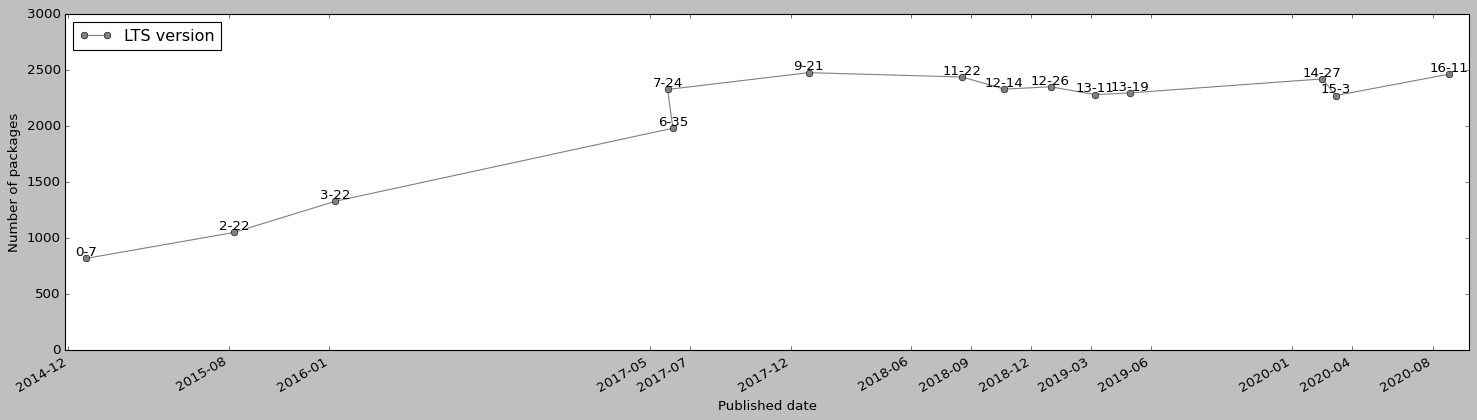

In [110]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(18,6))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)


#line = ax.plot(dates, total_pkgs, color='grey', marker='o',label='lts version')
plt.plot_date(lts_datetim, total_pkgs, linestyle='solid',color='grey',label='LTS version')
plt.gcf().autofmt_xdate()

for i in range(len(lts_list)):
    plt.text(lts_datetim[i],total_pkgs[i],lts_list[i],ha="center",va="bottom")

ax.set_yticks([0,500, 1000, 1500, 2000, 2500, 3000])
ax.set_yticklabels(['0','500', '1000', '1500', '2000', '2500', '3000'])

ax.set_xticks(dates)
ax.set_xticklabels(lts_date)

ax.set_xlabel('Published date')
ax.set_ylabel('Number of packages')
ax.legend(loc='upper left')

plt.savefig("graphs/rq0-1.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ0. 2 - Bar graph that shows the evolution of the main categories of the packages

In [17]:
from api import create_lts_obj
categories = ['data', 'web', 'control', 'text', 'network']
data = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
count_pkgs = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
df_by_cat = []


for idx, df in enumerate(df_by_category_list):
    aux_df = df[['package', 'category']]
    aux_df = aux_df.groupby(['category']).count().reset_index().rename(columns={"package": "count"})
    aux_df.loc[:, 'version'] = lts_list[idx]
    df_by_cat.append(aux_df.sort_values(by=['count'], ascending=False))
    
for category in categories:
    for idx, lts in enumerate(lts_list):
        total_pkgs = len(df_by_category_list[idx])
        aux = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count']) * 100 / total_pkgs   

        count = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count'])
        count_pkgs[category].append(count)
        data[category].append(aux)

others = []
per_others = []
for idx, lts in enumerate(lts_list):
    count = 0
    for category in count_pkgs:
        count += count_pkgs[category][idx]
    
    others.append(len(df_by_category_list[idx]) - count)
    per_others.append((len(df_by_category_list[idx]) - count) * 100 / len(df_by_category_list[idx]))

data['others'] = per_others
count_pkgs['others'] = others

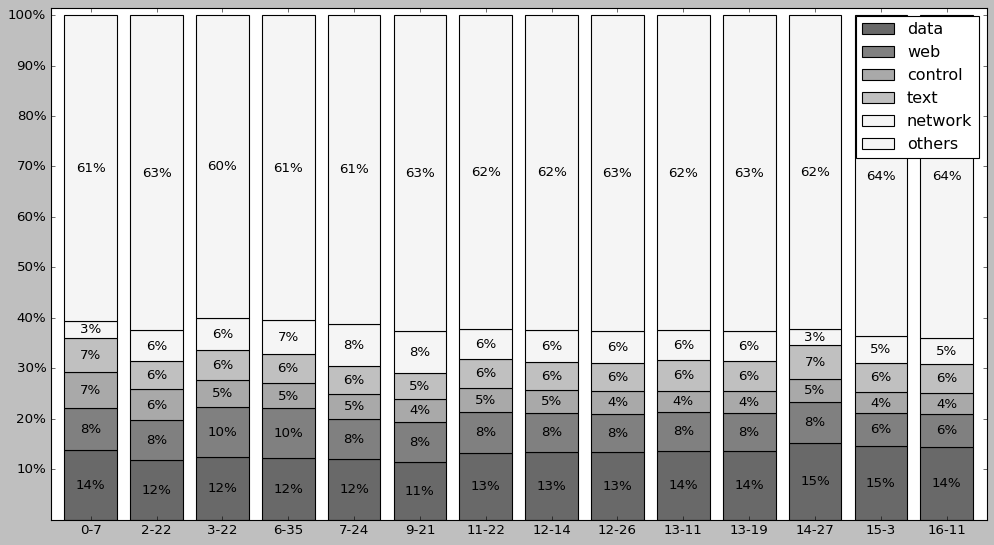

In [18]:
import operator
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

bar1 = ax.bar(x=lts_list, height=data['data'], width=0.8, color='dimgrey', align='center', label='data')
bar2 = ax.bar(x=lts_list, height=data['web'], width=0.8, bottom=data['data'], color='grey', label='web')
bar3 = ax.bar(x=lts_list, height=data['control'], width=0.8, bottom=list(map(operator.add, data['data'], data['web'])), color='darkgrey', label='control')
bar4 = ax.bar(x=lts_list, height=data['text'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, data['data'], data['web'])), data['control'])), color='silver', label='text')
bar5 = ax.bar(x=lts_list, height=data['network'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, list(map(operator.add, data['data'], data['web'])), data['control'])), data['text'])), color='whitesmoke', label='network')
bar6 = ax.bar(x=lts_list, height=data['others'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, list(map(operator.add, list(map(operator.add, data['data'], data['web'])), data['control'])), data['text'])), data['network'])), color='whitesmoke', label='others')

ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per)}%", data['data'])), label_type='center')
ax.bar_label(bar2, labels=list(map(lambda per: f"{round(per)}%", data['web'])), label_type='center')
ax.bar_label(bar3, labels=list(map(lambda per: f"{round(per)}%", data['control'])), label_type='center')
ax.bar_label(bar4, labels=list(map(lambda per: f"{round(per)}%", data['text'])), label_type='center')
ax.bar_label(bar5, labels=list(map(lambda per: f"{round(per)}%", data['network'])), label_type='center')
ax.bar_label(bar6, labels=list(map(lambda per: f"{round(per)}%", data['others'])), label_type='center')


ax.legend(loc='upper right', fontsize='large')
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.savefig("graphs/rq0-2.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ0. 3 - Bar graph that shows the evolution of the stabilities of the packages

In [19]:
categories = ['data', 'web', 'control', 'text', 'network']
data = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
count_pkgs = {
    'data': [],
    'web': [],
    'control': [],
    'text': [],
    'network': []
}
df_by_cat = []
for idx, df in enumerate(df_by_category_list):
    aux_df = df[['package', 'category', 'mtl-direct']]
    aux_df = aux_df[aux_df['mtl-direct'] == 1].groupby(['category']).count().reset_index().rename(columns={"package": "count"})   
    aux_df.loc[:, 'version'] = lts_list[idx]
    df_by_cat.append(aux_df.sort_values(by=['count'], ascending=False))

for category in categories:
    for idx, df in enumerate(df_by_category_list):
        total_pkgs = len(df_by_category_list[idx])
        aux = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count']) * 100 / total_pkgs   

        count = int(df_by_cat[idx][df_by_cat[idx]['category'] == category]['count']) 
        count_pkgs[category].append(count)
        data[category].append(aux)
others = []
per_others = []
for idx, lts in enumerate(lts_list):
    count = 0
    for category in count_pkgs:
        count += count_pkgs[category][idx]
    
    others.append(len(df_by_category_list[idx]) - count)
    per_others.append((len(df_by_category_list[idx]) - count) * 100 / len(df_by_category_list[idx]))

data['others'] = per_others
count_pkgs['others'] = others


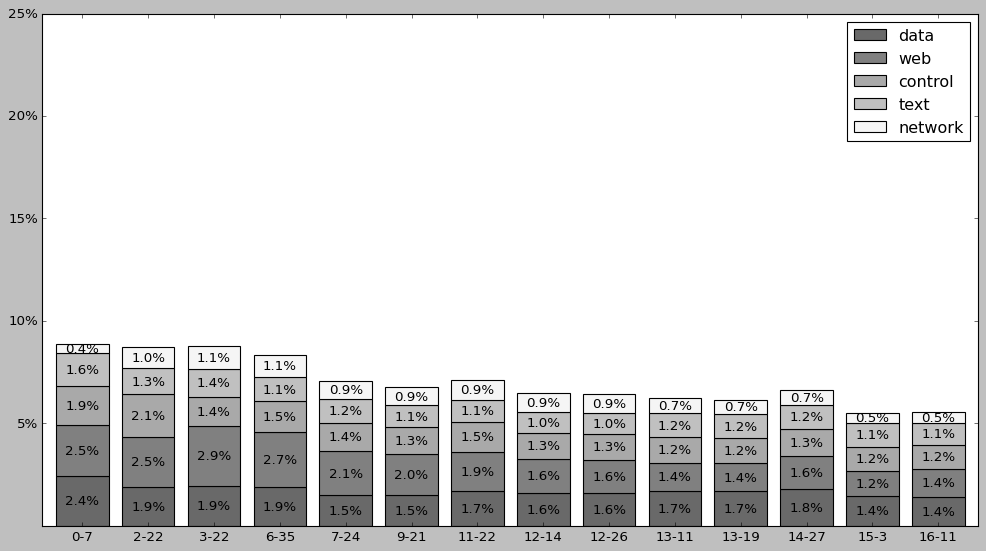

In [20]:
import operator
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

bar1 = ax.bar(x=lts_list, height=data['data'], width=0.8, color='dimgrey', align='center', label='data')
bar2 = ax.bar(x=lts_list, height=data['web'], width=0.8, bottom=data['data'], color='grey', label='web')
bar3 = ax.bar(x=lts_list, height=data['control'], width=0.8, bottom=list(map(operator.add, data['data'], data['web'])), color='darkgrey', label='control')
bar4 = ax.bar(x=lts_list, height=data['text'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, data['data'], data['web'])), data['control'])), color='silver', label='text')
bar5 = ax.bar(x=lts_list, height=data['network'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, list(map(operator.add, data['data'], data['web'])), data['control'])), data['text'])), color='whitesmoke', label='network')

ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per,1)}%", data['data'])), label_type='center')
ax.bar_label(bar2, labels=list(map(lambda per: f"{round(per,1)}%", data['web'])), label_type='center')
ax.bar_label(bar3, labels=list(map(lambda per: f"{round(per,1)}%", data['control'])), label_type='center')
ax.bar_label(bar4, labels=list(map(lambda per: f"{round(per,1)}%", data['text'])), label_type='center')
ax.bar_label(bar5, labels=list(map(lambda per: f"{round(per,1)}%", data['network'])), label_type='center')

ax.legend(loc='upper right', fontsize='large')
ax.set_yticks([5,10, 15, 20, 25])
ax.set_yticklabels(['5%','10%', '15%','20%', '25%'])

plt.savefig("graphs/rq0-3.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ0. 4 - Bar graph that shows the evolution of the main categories of the packages that depend of `mtl`

In [9]:
from api import create_lts_obj
stabilities = ['', 'experimental', 'stable', 'provisional', 'alpha', 'beta']
data = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
count_pkgs = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
stability_df = []

for idx, df in enumerate(df_list):
    aux_df = df[['package', 'stability']]
    aux_df = aux_df.groupby(['stability']).count().reset_index().rename(columns={"package": "count"})
    aux_df.loc[:, 'version'] = lts_list[idx]
    stability_df.append(aux_df.sort_values(by=['count'], ascending=False))

for stability in stabilities:
    for idx, lts in enumerate(df_list):
        total_pkgs = len(df_list[idx])
        
        aux = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count']) * 100 / total_pkgs
        count = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count'])
        count_pkgs[stability].append(count)
        data[stability].append(aux)

stabilities[0]='n/a'
for i in range (len(data['alpha'])):
    data['alpha'][i] = data['alpha'][i]+data['beta'][i]

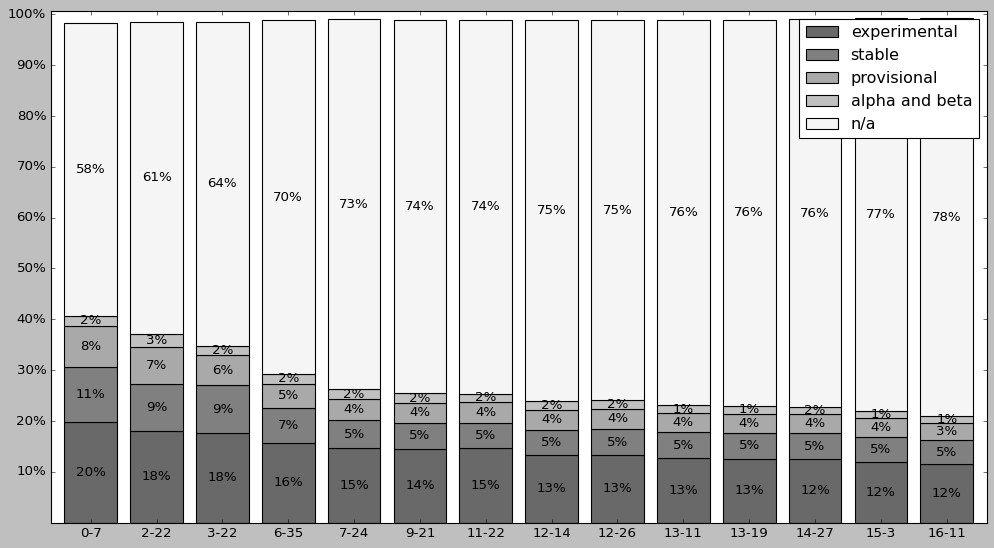

In [13]:
import operator
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

bar1 = ax.bar(x=lts_list, height=data['experimental'], width=0.8, color='dimgrey', align='center', label='experimental')
bar2 = ax.bar(x=lts_list, height=data['stable'], width=0.8, bottom=data['experimental'], color='grey', label='stable')
bar3 = ax.bar(x=lts_list, height=data['provisional'], width=0.8, bottom=list(map(operator.add, data['experimental'], data['stable'])), color='darkgrey', label='provisional')
bar4 = ax.bar(x=lts_list, height=data['alpha'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, data['experimental'], data['stable'])), data['provisional'])), color='silver', label='alpha and beta')
bar5 = ax.bar(x=lts_list, height=data[''], width=0.8, bottom=list(map(operator.add, list(map(operator.add, list(map(operator.add, data['experimental'], data['stable'])), data['provisional'])), data['alpha'])), color='whitesmoke', label='n/a')

ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per)}%", data['experimental'])), label_type='center')
ax.bar_label(bar2, labels=list(map(lambda per: f"{round(per)}%", data['stable'])), label_type='center')
ax.bar_label(bar3, labels=list(map(lambda per: f"{round(per)}%", data['provisional'])), label_type='center')
ax.bar_label(bar4, labels=list(map(lambda per: f"{round(per)}%", data['alpha'])), label_type='center')
ax.bar_label(bar5, labels=list(map(lambda per: f"{round(per)}%", data[''])), label_type='center')

ax.legend(loc='upper right', fontsize='large')
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.savefig("graphs/rq0-4.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ0. 5 - Bar graph that shows the evolution of the stabilities of the packages that depend of `mtl`

In [14]:
stabilities = ['', 'experimental', 'stable', 'provisional', 'alpha', 'beta']
data = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
count_pkgs = {
    '': [],
    'experimental': [],
    'stable': [],
    'provisional': [],
    'alpha': [],
    'beta': []
}
stability_df = []

for idx, df in enumerate(df_list):
    aux_df = df[['package', 'stability', 'mtl-direct']]
    aux_df = aux_df[aux_df['mtl-direct'] == 1].groupby(['stability']).count().reset_index().rename(columns={"package": "count"})
    aux_df.loc[:, 'version'] = lts_list[idx]
    stability_df.append(aux_df.sort_values(by=['count'], ascending=False))

for stability in stabilities:
    for idx, lts in enumerate(df_list):
        total_pkgs = len(df_list[idx])
        
        aux = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count']) * 100 / total_pkgs
        count = int(stability_df[idx][stability_df[idx]['stability'] == stability]['count'])
        count_pkgs[stability].append(count)
        data[stability].append(aux)
        
stabilities[0]='n/a'
for i in range (len(data['alpha'])):
    data['alpha'][i] = data['alpha'][i]+data['beta'][i]

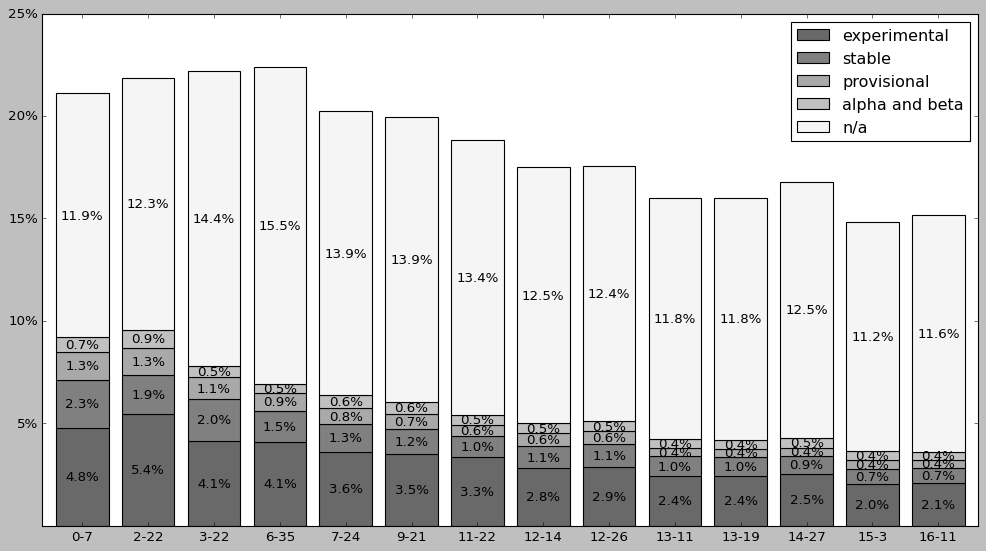

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

bar1 = ax.bar(x=lts_list, height=data['experimental'], width=0.8, color='dimgrey', align='center', label='experimental')
bar2 = ax.bar(x=lts_list, height=data['stable'], width=0.8, bottom=data['experimental'], color='grey', label='stable')
bar3 = ax.bar(x=lts_list, height=data['provisional'], width=0.8, bottom=list(map(operator.add, data['experimental'], data['stable'])), color='darkgrey', label='provisional')
bar4 = ax.bar(x=lts_list, height=data['alpha'], width=0.8, bottom=list(map(operator.add, list(map(operator.add, data['experimental'], data['stable'])), data['provisional'])), color='silver', label='alpha and beta')
bar5 = ax.bar(x=lts_list, height=data[''], width=0.8, bottom=list(map(operator.add, list(map(operator.add, list(map(operator.add, data['experimental'], data['stable'])), data['provisional'])), data['alpha'])), color='whitesmoke', label='n/a')

ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per,1)}%", data['experimental'])), label_type='center')
ax.bar_label(bar2, labels=list(map(lambda per: f"{round(per,1)}%", data['stable'])), label_type='center')
ax.bar_label(bar3, labels=list(map(lambda per: f"{round(per,1)}%", data['provisional'])), label_type='center')
ax.bar_label(bar4, labels=list(map(lambda per: f"{round(per,1)}%", data['alpha'])), label_type='center')
ax.bar_label(bar5, labels=list(map(lambda per: f"{round(per,1)}%", data[''])), label_type='center')

ax.legend(loc='upper right', fontsize='large')
ax.set_yticks([5,10, 15, 20, 25])
ax.set_yticklabels(['5%','10%', '15%','20%', '25%'])
plt.savefig("graphs/rq0-5.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Research Questions (RQs)

- **RQ 1.** What packages are the most used? Which of them are outside from the Stackage selection?
- **RQ 2.** How many dependencies of packages are outside from the Stackage selection (in)directly?
- **RQ 3.** How frequently are the packages updated? 

Regarding monads, we analyze the evolution of dependencies of monad modules available in the mtl package:

- **RQ 4.** How has the use of monads evolved?
- **RQ 5.** Are there packages that stopped using monads?


## RQ 1. What packages are the most used? Which of them are outside from the Stackage selection?

Consideramos el ultimo snapshot publicado en Stackage, especificamente el LTS 16.11. Utilizamos el campo **Dependencies** del DataFrame para obtener el listado de las dependencias de cada paquete y construimos un diccionario de todos los paquetes y sus dependencias. Contamos la cantidad de veces que fue requerido cada uno de ellos para posteriormente ordenarlos ascendentemente y filtrar el top 25 de los mas utilizados. Luego, restamos el conjunto de todos los paquetes seleccionados del LTS 16.11 a la lista de los top 25 mas utilizados para obtener los paquetes que no formaron parte de la seleccion.

Descubrimientos:

- Pregunta 1    
    - El top 5 de los paquetes mas usados se mantuvo a lo largo de las 14 versiones LTS analizadas, estos son: base, bytestring, containers, text, and transformers
    - MTL, tiene un rol importante en lenguaje y mantiene el top 6 a lo largo de las versiones consideras
- Pregunta 2
    - Descubrimos que dentro de los 22 paquetes mas usados en las versiones [15-3 y 16-11] se ubica quickchek un libreria utilzia para hacer tests que no se encuentra en la seleccion realizada por stackage
    - Analizando en profundiad este caso, descrubirmos que existen una gran cantidad de paquetes que son utilizados pero no son parte de la seleccion -> (Esto da paso a la pregunta 2) 

In [7]:
from api import get_pkgs_usage_count
top_25_pkgs = []
top_25_count = []
top_25_list = dict()

for idx, lts in enumerate(lts_list):
    top_25 = dict()
    packet_usage_count = get_pkgs_usage_count(df_list[idx])
    ordered_pkgs = sorted(packet_usage_count, key=packet_usage_count.get, reverse=True)[:25]

    for pkg in ordered_pkgs:
        top_25_pkgs.append(pkg)
        top_25_count.append(packet_usage_count[pkg])
        top_25[pkg] = packet_usage_count[pkg]
    
    top_25_list[lts] = top_25 

### Se encarga de generar el codigo de latex del top 10 de archivos

In [9]:
top = 1
latex = ''
list_lts_top25 = []
for lts in lts_list:
    list_top25 = list(top_25_list[lts].keys())
    list_lts_top25.append(list_top25)
    
for j in range(0,15):
    for i in range(len(list_lts_top25)-1):
        pkg = list_lts_top25[i][j]
        pkg_large = re.findall("-", pkg)
        if pkg_large:
            pkg_separate = pkg.split("-")
            pkg = pkg_separate[0]+'-\\\\' +pkg_separate[1]
            pkg = "\\makecell[tl]{"+pkg+"}"
        else:
            pkg = "\\makecell[tl]{"+pkg+"\\vspace{5mm}}"
        if i == 0:
            latex = latex + 'Top '+str(top)+' & '+pkg + ' & '
        elif i == len(list_lts_top25)-2:
            latex = latex + pkg + '\\\ \n'
        else:
            latex = latex + pkg + ' & '
    top += 1
    
print(latex)

'Top 6 & mtl & mtl & mtl & mtl & mtl & mtl & mtl & mtl & mtl & mtl & mtl & mtl & mtl\\\\ \nTop 7 & time & time & time & time & time & time & time & time & time & time & time & vector & vector\\\\ \nTop 8 & directory & directory & directory & directory & directory & vector & vector & vector & vector & vector & vector & time & deepseq\\\\ \nTop 9 & filepath & filepath & filepath & filepath & vector & aeson & aeson & aeson & aeson & aeson & aeson & deepseq & aeson\\\\ \nTop 10 & vector & vector & vector & aeson & filepath & directory & unordered-containers & deepseq & deepseq & deepseq & deepseq & aeson & time\\\\ \nTop 11 & array & aeson & aeson & vector & aeson & filepath & deepseq & unordered-containers & unordered-containers & unordered-containers & unordered-containers & directory & filepath\\\\ \nTop 12 & template-haskell & template-haskell & unordered-containers & unordered-containers & unordered-containers & unordered-containers & filepath & filepath & filepath & template-haskell 

In [6]:
from api import get_pkgs_usage_count, get_packages_out_of_stackage

for idx in range(0,14):
    pkgs_usage_count = get_pkgs_usage_count(df_list[idx])
    top = sorted(pkgs_usage_count, key=pkgs_usage_count.get, reverse=True)[:100]
    print(get_packages_out_of_stackage(top, df_list[idx]))
    print('')



['quickcheck', 'hunit', 'cabal', 'http', 'ghc']

['quickcheck', 'hunit', 'cabal', 'http']

['quickcheck', 'hunit', 'cabal', 'http', 'juicypixels']

['quickcheck', 'cabal', 'hunit', 'juicypixels', 'ghc']

['quickcheck', 'cabal', 'hunit']

['quickcheck', 'cabal', 'hunit', 'microlens']

['quickcheck', 'hunit', 'microlens', 'cabal']

['quickcheck', 'microlens', 'hunit', 'cabal']

['quickcheck', 'microlens', 'hunit', 'cabal']

['quickcheck', 'microlens', 'hunit', 'cabal']

['quickcheck', 'microlens', 'hunit', 'cabal']

['quickcheck', 'microlens', 'hunit', 'cabal']

['quickcheck', 'microlens', 'hunit', 'ghc']

['quickcheck', 'microlens', 'hunit', 'cabal']



## **RQ 2.** How many packages are outside of Stackage due to his (in)direct dependencies?

Procesamos todos los snapshots que consideramos en nuestra investigacion. Realizamos una busqueda en profundidad a las dependencias de cada paquete de los LTS, buscando alguna dependencia (in)directa que no se encontrara en la seleccion. Si este era el caso, se agregaba a un conjunto de paquetes que luego contabilizamos por cada LTS. Finalmente, calculamos el porcentage que estos paquetes representaban en cada snapshot.

* Cambiar leyenda por: (in)directly

- Mas del 12% de los paquetes quedan fuera de la seleccion indireamente al usar paquetes que non se encuentran en stackage
- Inclusive este valor aumento con el tiempo llegando a alcanzar el 17% en (<año>) y manteniendose en un 15% durante todas las versiones.
- algunos de los paquetes que tienen mas impacto en este problea son: ['quickcheck', 'microlens', 'hunit', 'cabal']
-  en el caso de cabal, este paquete fue deprecado por uno nuevo llamado Cabal, sin embargo, existen paquetes que todavia lo utilizan

In [21]:
from api import get_pkgs_out_transitively
out_transitive_pkgs = get_pkgs_out_transitively(df_list)

0-7 processed
2-22 processed
3-22 processed
6-35 processed
7-24 processed
9-21 processed
11-22 processed
12-14 processed
12-26 processed
13-11 processed
13-19 processed
14-27 processed
15-3 processed
16-11 processed


In [22]:
count_transitive = {}
per_transitive = {}
diff_transitive = {}  
diff_per_transitive = {} 

for idx, lts in enumerate(out_transitive_pkgs):
    count_transitive[lts] = out_transitive_pkgs[lts]
    per_transitive[lts] = round(out_transitive_pkgs[lts]*100 / len(df_list[idx]), 1)
    diff_transitive[lts] = len(df_list[idx]) - out_transitive_pkgs[lts]
    diff_per_transitive[lts] = 100 - per_transitive[lts]
    
index = list(per_transitive.keys())
count_values = list(count_transitive.values())
per_values = list(per_transitive.values())
diff_values = list(diff_transitive.values())
diff_per_values = list(diff_per_transitive.values())

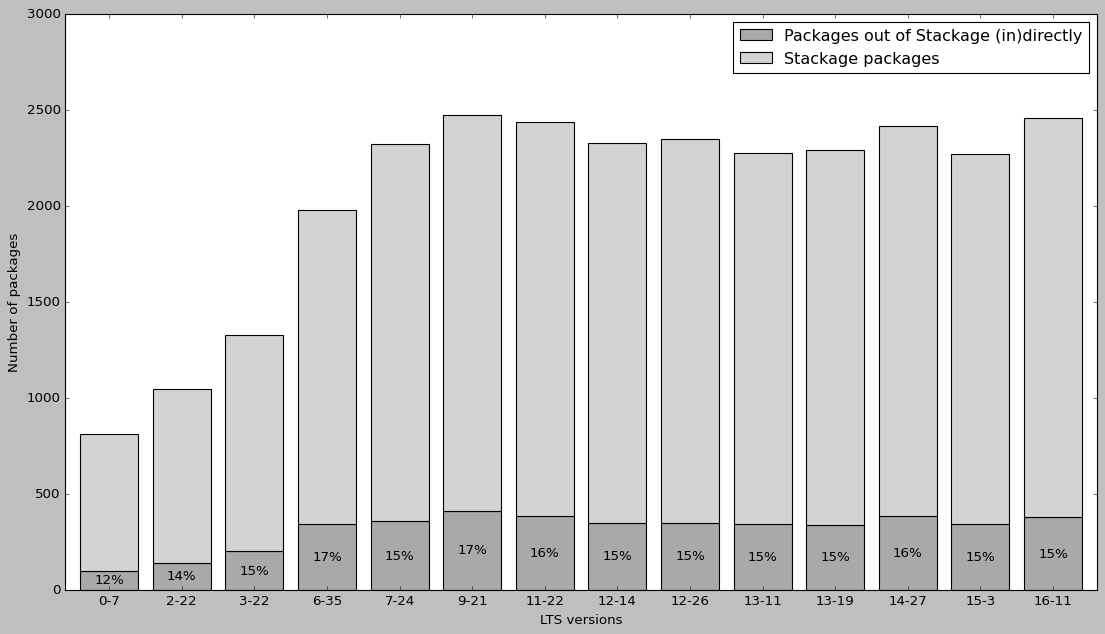

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(bottom=0.1, right=1.2, top=1)
bar1 = ax.bar(x=lts_list, height=count_values, width=0.8, color='darkgrey', align='center', label='Packages out of Stackage (in)directly')
bar2 = ax.bar(x=lts_list, height=diff_values, width=0.8, bottom=count_values, color='lightgrey', label='Stackage packages')
ax.legend(loc='best')
ax.set_xlabel('LTS versions')
ax.set_ylabel('Number of packages')

ax.set_yticks([0, 500, 1000, 1500, 2000, 2500, 3000])
ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per)}%", per_values)), label_type='center')
plt.savefig("graphs/rq2.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [73]:
import statistics
mean = statistics.mean(list(per_transitive.values()))
print(f'average over time {mean:.1f}%')

average over time 15.2%


## RQ 3. How frequently are the packages updated? 

Construimos un nuevo DafaFrame que nos muestra la version de cada paquete en cada LTS que llamamos `versions_df`. Procesamos este DataFrame contando la cantidad de veces en que cada paquete actualizo su version a lo largo del tiempo. Luego, calculamos el porcentaje de paquetes que actualizo su version en cada LTS respecto a la cantidad de paquetes totales en el snapshot anterior.

- La primera version tiene alrededor de 800 paquetes y el porcentaje de actualizacion depende de la version anterior
- Al inicio de las versiones se actualizaron una gran cantidad de paquetes entre cada snapshot (2-22, 3-22 y 6-35), sin embargo el periodo de tiempo (+6 meses) existente entre estas versiones es superior, ya que no existia regularidad en la publicacion de versiones
- Durante las versiones 12-14, 12-26, 13-11 y 13-19 se ve una disminucion en la cantidad de paquetes actualziados sin emargo el margen de tiempo (1-3 meses) entre estas versiones es bastante menor a las otras publicacinoes.
- En promedio se actializan el 28% de los paquetes y la desviacion estandar X

In [74]:
from api import get_versions_df, get_update_count_df, get_count_updated_packages_by_lts
versions_df = get_versions_df(df_list)

In [75]:
update_count_df = get_update_count_df(df_list, versions_df)

In [76]:
count_updated_packages_by_lts = get_count_updated_packages_by_lts(df_list, update_count_df)

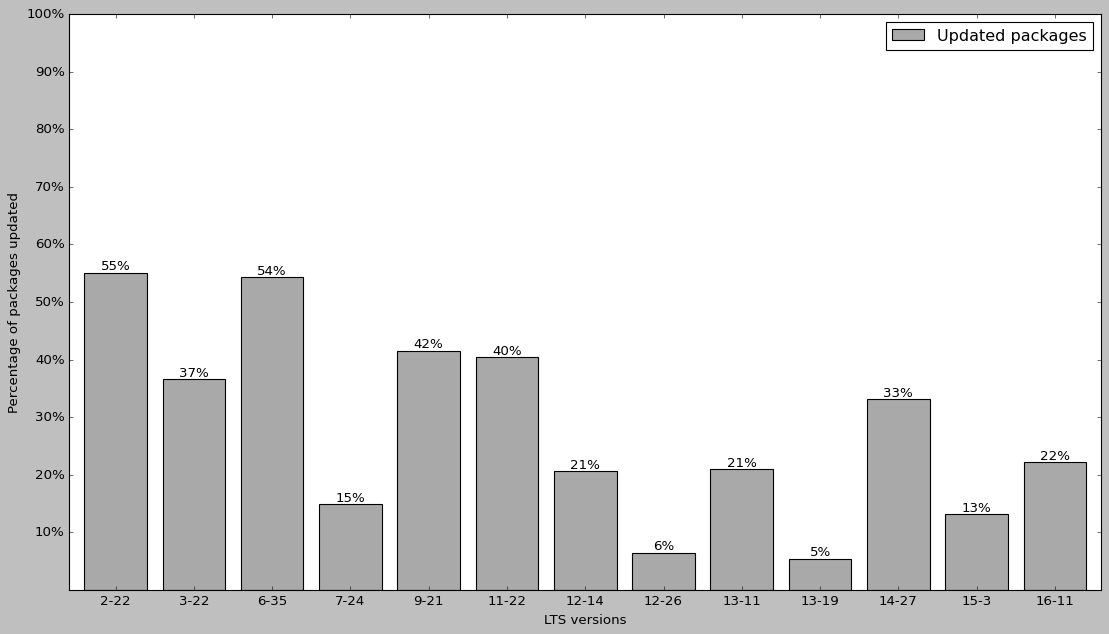

In [98]:
index = list(count_updated_packages_by_lts.keys())
updated_packages = list(count_updated_packages_by_lts.values())

fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(bottom=0.1, right=1.2, top=1)

bar1 = ax.bar(index, updated_packages, width=0.8, color='darkgrey', align='center', label='Updated packages')
ax.bar_label(bar1, labels=list(map(lambda per: f"{round(per)}%", updated_packages)))

ax.legend(loc='best')
ax.set_xlabel('LTS versions')
ax.set_ylabel('Percentage of packages updated')
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.savefig("graphs/rq3.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ 4. How has the use of monads evolved?

Para responder esta pregunta fueron necesarios los datos obtenidos despues analizar estaticamente (parsear) el codigo de cada paquete. El primer paso fue contabilizar por cada LTS la cantidad de paquetes que utiliza cada monada usando los campos de tipo flag descritos. Con estos datos prodecimos a calcular el valor porcentual respecto al total de monadas utilizadas en cada LTS para finalmente, visualizar la distribucion del uso de las monadas en un grafico de barra por cada version.

- Existe una relacion inversamente proprcional entre el uso de monadas de error y de execpcion.
- Se produjo una considerable adopcion del uso de la monada de excepcion, que paso de tener un uso casi nulo al comienzo a alcanzar casi el 10% del uso de la monadas en la version 16-22
- Obeservamos que la monada de estados se mantiene liderando la distrubcion a lo largo del tiemp
- En general las distrubciones tienen pocas variaciones a pesar de haber aumentado la cantidad de paquetes 3 veces entre el primer y ultimo lts

In [78]:
from api import compute_monad_usage_by_df, create_lts_obj
monads_used = [0, 1, 2, 3, 4, 5, 6, 7, 8]
data = create_lts_obj()
monads_used_df = []

for idx, df in enumerate(df_list):
    df = df[df['mtl-direct'] == 1]
    df = compute_monad_usage_by_df(df)
    aux_df = df[['MonadsUsed', 'package']]
    aux_df = aux_df.groupby(['MonadsUsed']).count().reset_index().rename(columns={'package': 'count'})
    monads_used_df.append(aux_df)

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [79]:
from api import compute_monad_usage_by_df, create_lts_obj
monads_type = ['State', 'Reader', 'Trans', 'Writer', 'Error', 'Except', 'Identity', 'RWS', 'Continuation', 'List']
monads_type_df_list = []
data = [[], [], [], [], [], [], [], [], [], []]
 
for idx, df in enumerate(df_list):
    mtl_df = df[df['mtl-direct'] == 1]
    mtl_df = compute_monad_usage_by_df(mtl_df)
    monad_type_series = mtl_df[monads_type].sum().sort_values()
    monad_type_df = pd.DataFrame({ "type": monad_type_series.index, "count": monad_type_series.values })
    monads_type_df_list.append(monad_type_df)
    
for num, monad in enumerate(monads_type):    
    for idx, lts in enumerate(lts_list):
        aux = int(monads_type_df_list[idx][monads_type_df_list[idx]['type'] == monad]['count'])
        sum = monads_type_df_list[idx].sum().values[1]
        per = aux * 100 / sum
        data[num].append(per)

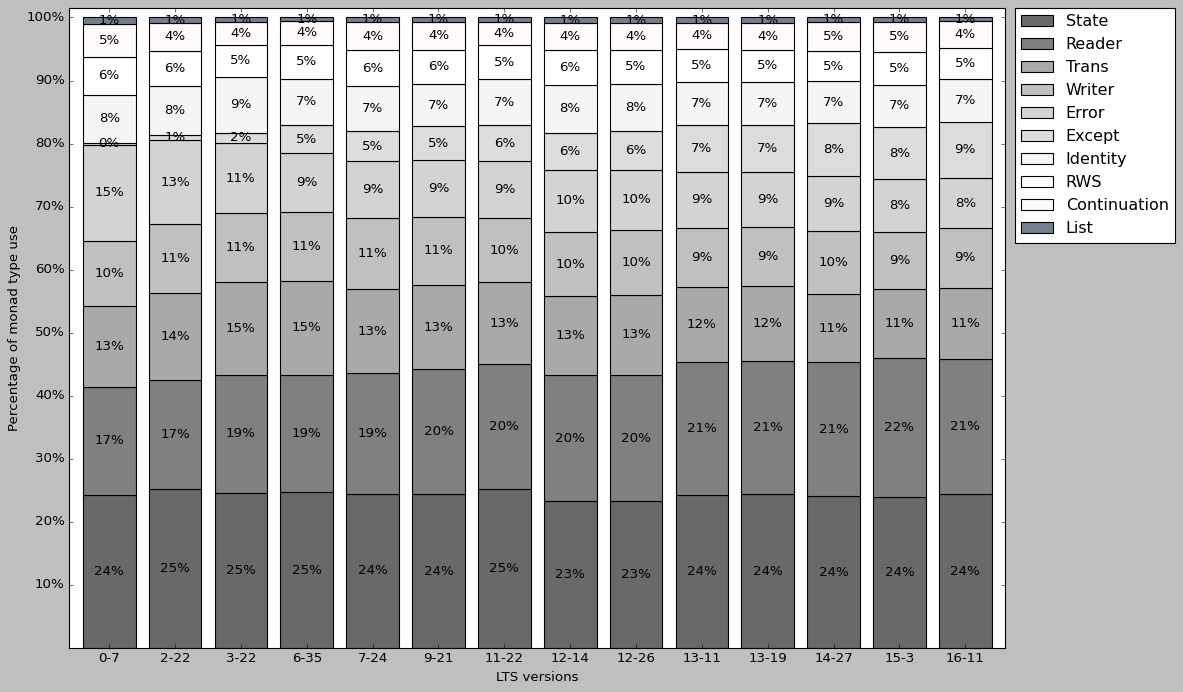

In [92]:
import operator
fig, ax = plt.subplots(figsize=(12, 10))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

def calculate_bottom(data, bar_idx):
    if bar_idx == 0:
        return 0
    
    cumsum = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for idx in range(0, bar_idx):
        cumsum = list(map(operator.add, cumsum, data[idx]))
    
    return cumsum

monads_type = ['State', 'Reader', 'Trans', 'Writer', 'Error', 'Except', 'Identity', 'RWS', 'Continuation', 'List']
colors = colors = ['dimgrey', 'grey', 'darkgrey', 'silver', 'lightgrey', 'gainsboro', 'whitesmoke', 'white', 'snow', 'slategrey']
for idx, monad in enumerate(monads_type):
    bar = ax.bar(x=lts_list, height=data[idx], bottom=calculate_bottom(data, idx), width=.8, color=colors[idx], align='center', label=monad)
    ax.bar_label(bar, labels=list(map(lambda per: f"{round(per)}%", data[idx])), label_type='center', color='black')
    
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
ax.set_xlabel('LTS versions')
ax.set_ylabel('Percentage of monad type use')
plt.savefig("graphs/rq4.pdf", format='pdf', bbox_inches='tight')
plt.show()

## RQ 5.  How many packages that depend of mtl were removed? Are there packages that stopped using monads ?

How many packages that depend of mtl were removed? - Para saber cuantos paquetes fueron removidos que dependen de mtl tambien nos gustaria hacer la compracion con los que fueron agregados. Para esto creamos un DataFrame de continuidad de los paquetes que nos indica que paquete existe en la version y ademas, si utiliza monadas en aquel momento. Luego, iteramos sobre este DataFrame para contar cuantos paquetes se removieron y agregaron en cada version. Tranformamos los valores contabilizados a su forma porcentual respecto a la cantidad total de paquetes en la version. Finalmente, utilizamos graficos de linea para visualizar la fructuacion en el tiempo de los paquetes removidos versus los agregados, con apoyo de un grafico de barra para visualizar el valor final en cada LTS.

Pregunta 1
- La primera version parte con 175 paquetes que usan mtl (Agregar o no la primera version)
- al comienzo hubo una tendencia de crecimiento en la cantidad de paquetes que se agregaban que utilizaban mtl, pero esto puede tener relacion con la cantiad de paqutes que se agregaron en aquel momento.
- Sin embargo vemos una fluctuacion de paquetes agregados y removidos de mtl importantes, pj en la version 11-22 que se agregaron alrededor de 75 paquetes pero se removieron 115, el movimiento de paquetes es importate.
- Posterior a las 4 primeras versinones, la suma total de paquetes removidos es mayor a la cantidad de paquete agregados

Pregunta 2
- Este caso no sucede muy amenudo
- La mayor fluctuacion la vemos en la lts 9-21, en donde 10 paquetes comenzaron a usar mtl y 6 dejaron de usar mtl
- Son tan pocos los casos que no se puede asegurar una tendencia
- Inclusive durante el periodo 12-26 - 13-19 no existe ninguna variacion (lts's con poco margen de tiempo)
- Se cree que este cambio no fue tan drastico porque el lenguaje empuja a mantener el uso de monadas y no existe hasta ahora un cambio pragmatico en la programacion de este.

In [20]:
from api import get_all_time_packages, build_mtl_continuity_matrix
mtl_continuity_df = build_mtl_continuity_matrix(df_list, get_all_time_packages(df_list))

In [21]:
from api import get_added_packages_mtl_by_lts, get_removed_packages_mtl_by_lts
added_mtl_pkgs_count = get_added_packages_mtl_by_lts(mtl_continuity_df)
removed_mtl_pkgs_count = get_removed_packages_mtl_by_lts(mtl_continuity_df)
total = [(x - y) for idx, (x, y) in enumerate(zip(added_mtl_pkgs_count, removed_mtl_pkgs_count))]

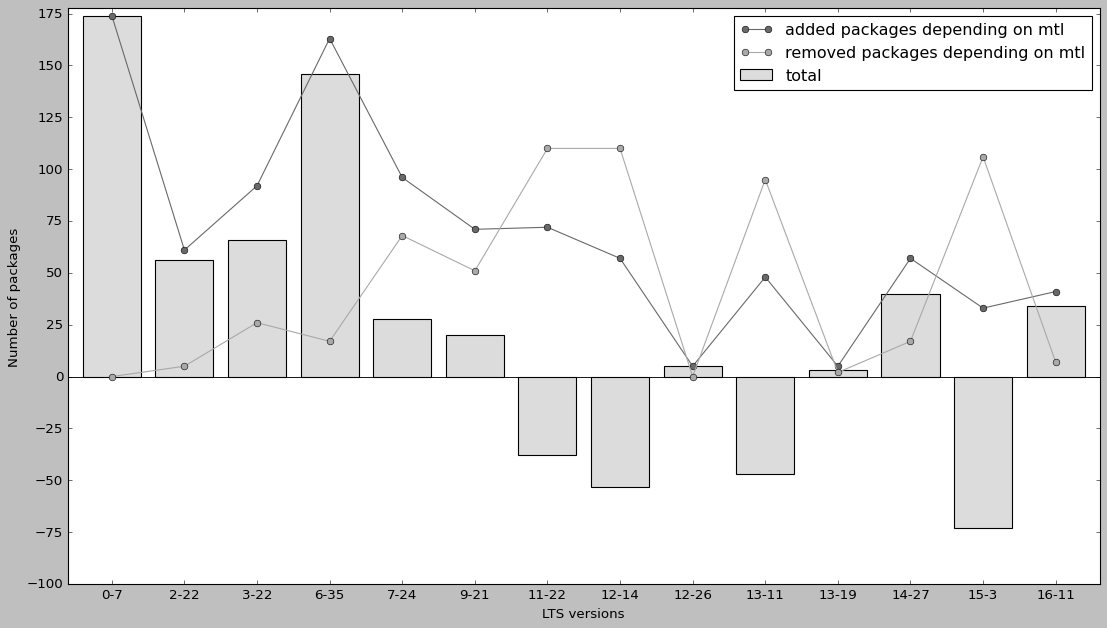

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(bottom=0.1, right=1.2, top=1)
ax.axhline(0, color='black', linewidth=0.8)
bar = ax.bar(lts_list, total, width=0.8, color='gainsboro', align='center', label='total')
line = ax.plot(lts_list, added_mtl_pkgs_count, color='dimgrey', marker='o', label='added packages depending on mtl')
line = ax.plot(lts_list, removed_mtl_pkgs_count, color='darkgrey', marker='o', label='removed packages depending on mtl')
ax.legend(loc='best')
ax.set_xlabel('LTS versions')
ax.set_ylabel('Number of packages')
ax.set_yticks([-100, -75, -50, -25, 0, 25, 50, 75, 100, 125, 150, 175])
plt.savefig("graphs/rq5_1.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [96]:
from api import get_packages_started_use_mtl, get_packages_stopped_use_mtl
packages_started_use_mtl_count = get_packages_started_use_mtl(mtl_continuity_df)
packages_stopped_use_mtl_count = get_packages_stopped_use_mtl(mtl_continuity_df)
total = [(x - y) for idx, (x, y) in enumerate(zip(packages_started_use_mtl_count, packages_stopped_use_mtl_count))]

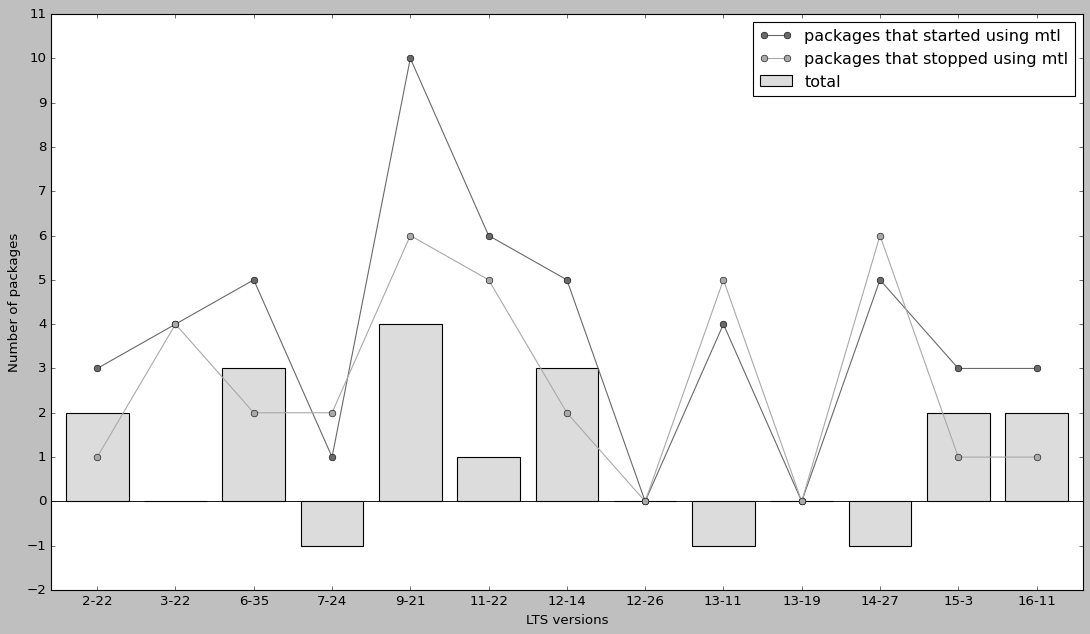

In [97]:
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(bottom=0.1, right=1.2, top=1)
ax.axhline(0, color='black', linewidth=0.8)
bar = ax.bar(lts_list[1:], total[1:], width=0.8, color='gainsboro', align='center', label='total')
line = ax.plot(lts_list[1:], packages_started_use_mtl_count[1:], color='dimgrey', marker='o', label='packages that started using mtl')
line = ax.plot(lts_list[1:], packages_stopped_use_mtl_count[1:], color='darkgrey', marker='o', label='packages that stopped using mtl')
ax.legend(loc='best')
ax.set_xlabel('LTS versions')
ax.set_ylabel('Number of packages')
ax.set_yticks([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
plt.savefig("graphs/rq5_2.pdf", format='pdf', bbox_inches='tight')
plt.show()